# <center> Python EDA: Exploring Second-Hand Clothing Shop Data</center>

<img src="https://images.unsplash.com/photo-1525507119028-ed4c629a60a3?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1935&q=80" style="width: 500px">/

## Table of Contents:
* [1. Discovery (identificazione del problema e degli obiettivi)](#first-bullet)
    * [1.1 Linee guida del progetto](#first1-bullet)
* [2. Data Cleaning & Data Transformation](#second-bullet)
* [3. EDA](#third-bullet)
* [4. Clustering with K-Means](#fourth-bullet)
* [5. Conclusioni](#fifth-bullet)

## 1. Discovery (identificazione del problema e degli obiettivi)<a class="anchor" id="first-bullet"></a>

Partendo da questo dataset che rappresenta i dati di vendita di un marketplace di abbigliamento second hand lo scopo del notebook è fare un'analisi generale sulle vendite nell'anno 2021 sulla piattaforma, individuandone trend e caratteristiche. In seguito poi dividere in cluster i dati così da poter creare delle Personas di venditori "tipo" (che mostrerò poi in una Dashboard Tableau).

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

warnings.filterwarnings("ignore")

In [17]:
data = pd.read_csv(r'C:\Users\arena\Downloads\Fashion_data Final Project.csv')

In [18]:
data

,user_uuid,category,designer_id,language,level,country,purchase_date,platform,item_id,stars,subscription_date
0,183,belt,120,en,cheap,uk,13-7-2022,android,3521,1,20-8-2021
1,134,underwear,102,it,cheap,it,2-5-2023,android,6239,2,20-11-2022
2,158,belt,106,it,cheap,it,6-8-2021,pc,3618,3,18-3-2020
3,82,shoes,102,it,premium,it,18-7-2023,android,5281,4,21-1-2022
4,201,shoes,113,en,average,uk,7-5-2023,android,5260,1,25-11-2022
...,...,...,...,...,...,...,...,...,...,...,...
994,3,belt,104,fr,average,fr,7-6-2023,android,3791,2,22-7-2020
995,81,shoes,101,it,premium,it,10-11-2023,android,587,2,23-8-2022
996,173,activewear,101,fr,premium,fr,22-11-2023,android,6882,2,12-12-2021
997,41,belt,109,fr,cheap,fr,12-12-2023,android,3558,5,1-8-2021


Il dataset contiene le seguenti colonne:

**user_uuid:** Indica l'id dell'utente che vende  
**category:** Indica il tipo di prodotto che viene venduto  
**designer_id:** Indica lo "stitista" del prodotto  
**language:** Indica la lingua parlata dal venditore  
**level:** Indica la fascia di prezzo di prodotto venduta  
**country:** Indica il paese di provenienza del venditore  
**purchase_date:** Indica la data di vendita  
**platform:** Indica la piattaforma su cui viene venduto il prodotto  
**item_id:** Indica l'id dell'oggetto venduto  
**stars:** Punteggio recensione da 1 a 5

In [19]:
#controllo valori duplicati
data.isna().sum()

user_uuid            0
category             0
designer_id          0
language             0
level                0
country              0
purchase_date        0
platform             0
item_id              0
stars                0
subscription_date    0
dtype: int64

Non ci sono valori nulli.

In [20]:
#guardo le info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_uuid          999 non-null    int64 
 1   category           999 non-null    object
 2   designer_id        999 non-null    int64 
 3   language           999 non-null    object
 4   level              999 non-null    object
 5   country            999 non-null    object
 6   purchase_date      999 non-null    object
 7   platform           999 non-null    object
 8   item_id            999 non-null    int64 
 9   stars              999 non-null    int64 
 10  subscription_date  999 non-null    object
dtypes: int64(4), object(7)
memory usage: 86.0+ KB


Le colonne 'user_uuid', 'designer_id', 'item_id' non ha senso trattarle come numeriche e vanno trasformate. Per quanto riguarda le date le trasformerò in tipo datetime e poi mi prendo mese e anno.

### 1.1 Linee guida del progetto <a class="anchor" id="first1-bullet"></a>

Per creare un percorso al progetto mi pongo delle domande in modo da avere dei mini-obiettivi da raggiungere a cui dare una risposta tramite l'analisi dati:
* **Analizzando le variabili categoriche, quali sono le categorie e le fasce di prezzo più vendute? E da quale paese e su quale piattaforma?**
* **Come si relazionano tra di loro le variabili categoriche? Cosa ci dicono?**
* **La data di iscrizione e la data di vendita mostrano una qualche tendenza?**
* **Ci sono dei mesi in cui si vende più un certo tipo di prodotto, o su una certa fascia di prezzo o su un certo paese?**
* **Quali sono le caratteristiche che più determinano una recensione alta o bassa?**

## 2. Data Cleaning & Data Transformation<a class="anchor" id="second-bullet"></a>

In [21]:
#trasformo in "object" colonne che sono id
columns_to_convert = ['user_uuid', 'designer_id', 'item_id']
data[columns_to_convert] = data[columns_to_convert].astype('object')

In [22]:
#trasformo in formato datetime le variabili "date" e mi ottengo solo il mese e anno
data['purchase_date'] = pd.to_datetime(data['purchase_date'])
data['purchase_month'] = data['purchase_date'].dt.month
data['purchase_year'] = data['purchase_date'].dt.year

data['subscription_date'] = pd.to_datetime(data['subscription_date'])
data['subscription_year'] = data['subscription_date'].dt.year
data['subscription_month'] = data['subscription_date'].dt.month

In [23]:
#elimino la colonna "language" perchè praticamente uguale a "country"
#elimino anche gli id di item e designer perchè essendo solo id non riesco poi a dargli un "senso"
data.drop(['language','item_id','designer_id'],axis=1,inplace=True)

In [24]:
#prendo solo i dati del 2021
data2021 = data[data['purchase_year'] == 2021]

In [25]:
#creo una nuova colonna, voglio vedere quante vendite fa lo stesso venditore
total_sales_counts = data2021['user_uuid'].value_counts()
data2021['total_sales_count'] = data2021['user_uuid'].map(total_sales_counts)

In [26]:
#controllo se ci sono eventuali duplicati
len(data2021[data2021.duplicated()])

0

## 3. EDA<a class="anchor" id="third-bullet"></a>

In [27]:
#dò un'occhiata a com'è distribuita l'unica variabile numerica
data2021['stars'].describe()

count    93.000000
mean      2.763441
std       1.394070
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: stars, dtype: float64

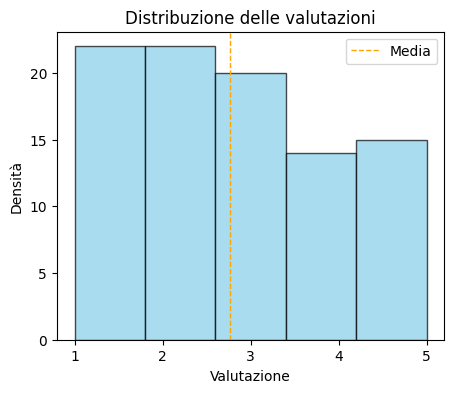

In [28]:
plt.figure(figsize=(5, 4))
plt.hist(data2021['stars'], bins=5, edgecolor='k', color='skyblue', alpha=0.7)
plt.axvline(data2021['stars'].mean(), color='orange', linestyle='dashed', linewidth=1, label='Media')
plt.xlabel('Valutazione')
plt.ylabel('Densità')
plt.title('Distribuzione delle valutazioni')
plt.xticks(range(1, 6))

plt.legend()
plt.show()

La distribuzione delle valutazioni mostra una media di 2.76, con dati comunque in maggioranza tra 1 e 2 quindi la maggior parte delle valutazioni sono basse.

In [29]:
#creo dizionari per decidere le colorazioni
category_palette = {
    'activewear': '#00bfff',
    'belt': '#8b4513',
    'bottom': '#800080',
    'dress': '#87ceeb',
    'shirt': '#000080',
    'shoes': '#000000',
    'underwear': '#ff69b4'
}

level_palette = {
    'average' : '#f5f5dc',
    'cheap' : '#00ff00',
    'premium' : '#000080'}

platform_palette = {
    'android' : '#32cd32',
    'apple' : '#c0c0c0',
    'pc' : '#0000ff'
}

country_palette = {
    'fr' : '#0074d9',
    'it' : '#00ff00',
    'uk' : '#000080'
}

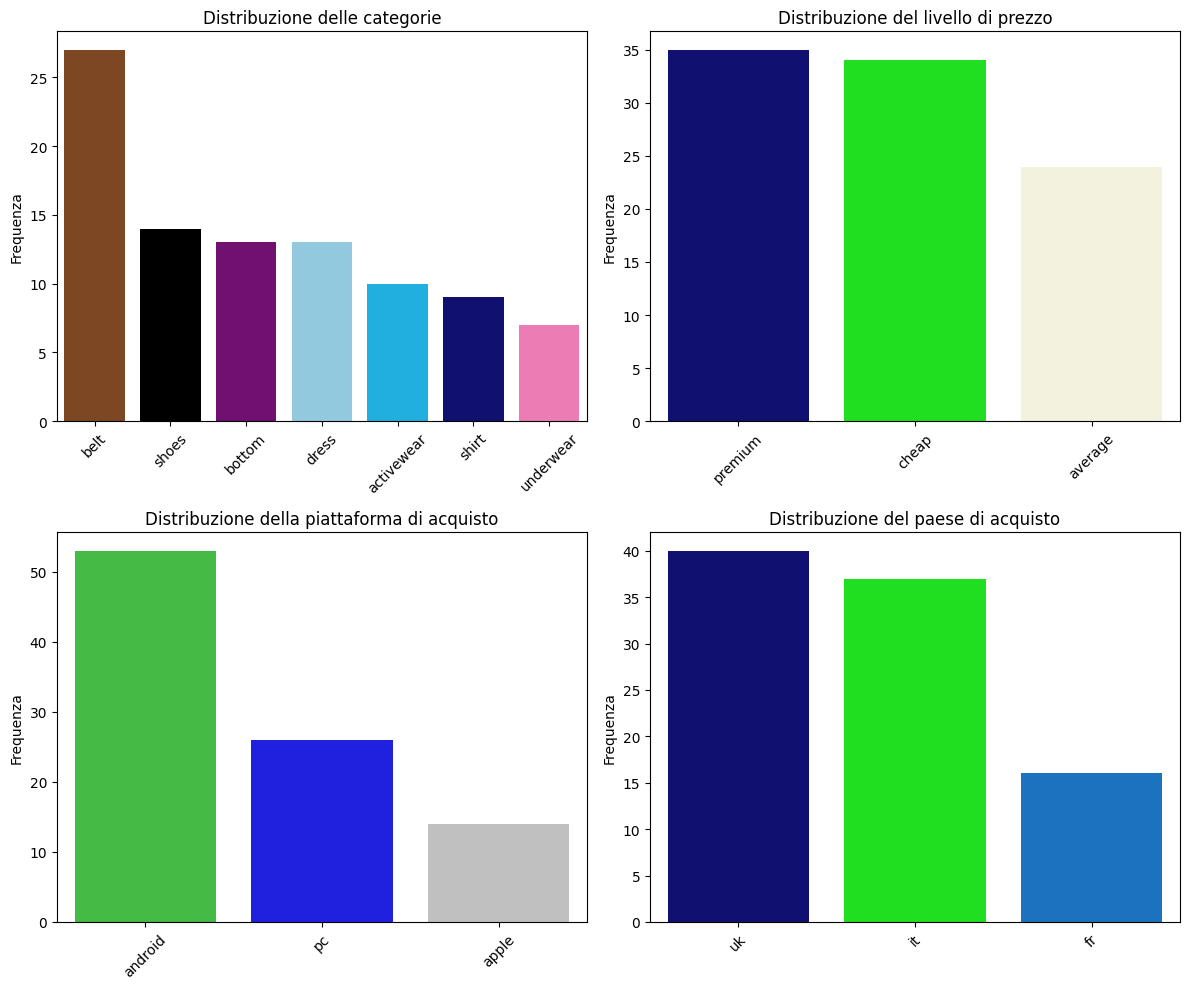

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.countplot(data=data2021, x='category', order=data2021['category'].value_counts().index, palette=category_palette, ax=axs[0, 0])
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Frequenza')
axs[0, 0].set_title('Distribuzione delle categorie')
axs[0, 0].tick_params(axis='x', rotation=45) 

sns.countplot(data=data2021, x='level', order=data2021['level'].value_counts().index, palette=level_palette, ax=axs[0, 1])
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('Frequenza')
axs[0, 1].set_title('Distribuzione del livello di prezzo')
axs[0, 1].tick_params(axis='x', rotation=45)

sns.countplot(data=data2021, x='platform', order=data2021['platform'].value_counts().index, palette=platform_palette,
              ax=axs[1, 0])
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('Frequenza')
axs[1, 0].set_title('Distribuzione della piattaforma di acquisto')
axs[1, 0].tick_params(axis='x', rotation=45)

sns.countplot(data=data2021, x='country', order=data2021['country'].value_counts().index, palette=country_palette,
              ax=axs[1, 1])
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('Frequenza')
axs[1, 1].set_title('Distribuzione del paese di acquisto')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

Il prodotto nettamente più venduto sono le cinture, praticamente il doppio sulle scarpe al secondo posto con pantaloni e vestiti allo stesso livello poco sotto. 

Sono i premium i prodotti più venduti, è probabilmente più facile su queste piattaforme che la gente cerchi prodotti che nuovi costano tanto, cercando quindi un risparmio. In ogni caso la fascia economica è di pochissimo sotto e anche quella media è abbastanza venduta. 

La maggior parte delle vendite avviene nettamente tramite Android, più del doppio del pc al secondo posto e quasi 4 volte più di Apple. Qui sicuramente influisce l'uso molto più alto che tutti facciamo di Smartphone rispetto al pc, nonostante Apple all'ultimo posto ma ha sicuramente meno utenti di Android. 

In Uk e in Italia si trovano la maggior parte degli utenti, circa il doppio dei francesi.

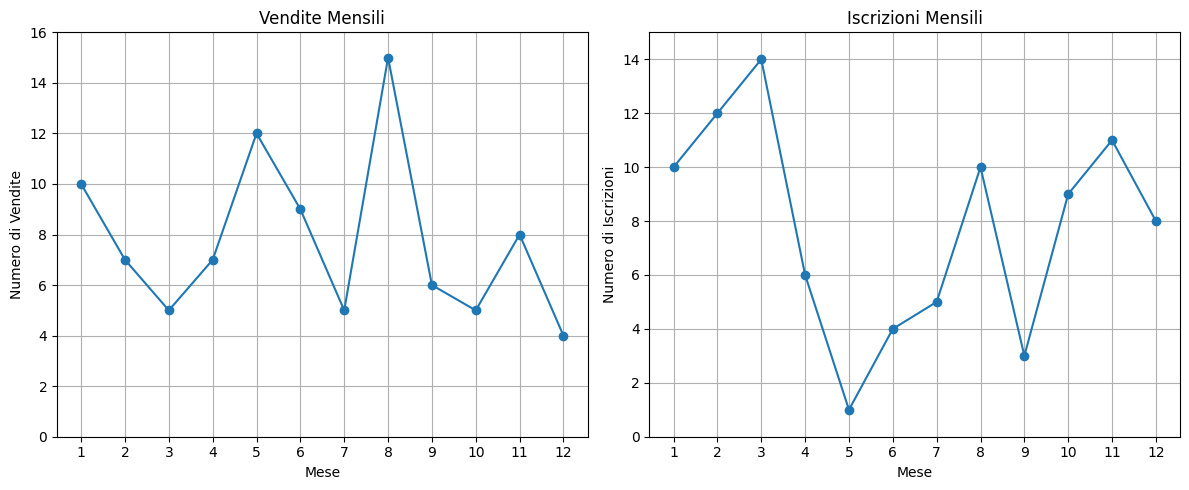

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sales_per_month = data2021['purchase_month'].value_counts().sort_index()
axs[0].plot(sales_per_month.index, sales_per_month.values, marker='o')
axs[0].set_title('Vendite Mensili')
axs[0].set_xlabel('Mese')
axs[0].set_ylabel('Numero di Vendite')
axs[0].set_xticks(range(1, 13))
axs[0].set_ylim(0, max(sales_per_month.values) + 1)
axs[0].grid(True)

subscriptions_per_month = data2021['subscription_month'].value_counts().sort_index()
axs[1].plot(subscriptions_per_month.index, subscriptions_per_month.values, marker='o')
axs[1].set_title('Iscrizioni Mensili')
axs[1].set_xlabel('Mese')
axs[1].set_ylabel('Numero di Iscrizioni')
axs[1].set_xticks(range(1, 13))
axs[1].set_ylim(0, max(subscriptions_per_month.values) + 1)
axs[1].grid(True)

plt.tight_layout()

plt.show()

Non si riesce a dare un vero senso all'andamento delle vendite che sembra altalenante. I mesi che vanno meglio sono comunque maggio, agosto e gennaio. Mese peggiore dicembre.

Per quanto riguarda le iscrizioni embra esserci invece un trend, nei mesi invernali le iscrizioni sono di più che nei mesi estivi.

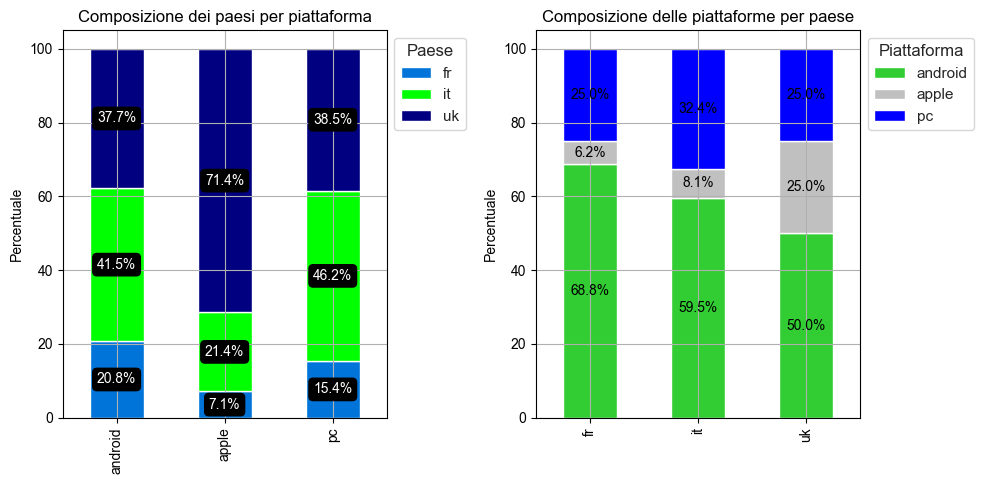

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax1 = axs[0]

platform_country_distribution = data2021.groupby(['platform', 'country']).size().unstack(fill_value=0)
platform_country_distribution_percent = platform_country_distribution.div(platform_country_distribution.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
platform_country_distribution_plot = platform_country_distribution_percent.plot(
    kind='bar', stacked=True, ax=ax1,color=[country_palette[col] for col in platform_country_distribution.columns])

for container in platform_country_distribution_plot.containers:
    values = [bar.get_height() for bar in container]
    total = sum(values)
    for bar, value in zip(container, values):
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            '{:.1f}%'.format(value),
            va='center',
            ha='center',
            fontsize=10,
            color='white',
            bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.3')
        )

ax1.set_title('Composizione dei paesi per piattaforma')
ax1.set_xlabel('')
ax1.set_ylabel('Percentuale')
ax1.legend(title='Paese', bbox_to_anchor=(1, 1))

ax2 = axs[1]

country_platform_distribution = data2021.groupby(['country', 'platform']).size().unstack(fill_value=0)
country_platform_distribution_percent = country_platform_distribution.div(country_platform_distribution.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
country_platform_plot = country_platform_distribution_percent.plot(
    kind='bar', stacked=True, ax=ax2,color=[platform_palette[col] for col in country_platform_distribution.columns])

for container in country_platform_plot.containers:
    values = [bar.get_height() for bar in container]
    total = sum(values)
    for bar, value in zip(container, values):
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            '{:.1f}%'.format(value),
            va='center',
            ha='center',
            fontsize=10,
            color='black'
        )

ax2.set_title('Composizione delle piattaforme per paese')
ax2.set_xlabel('')
ax2.set_ylabel('Percentuale')
ax2.legend(title='Piattaforma', bbox_to_anchor=(1, 1))

plt.tight_layout()

plt.show()

Questi grafici ci dicono che gli utilizzatori di Android e PC sono in maggioranza italiani e britannici. Molto interessante il fatto che il 71% delle vendite Apple riguarda il Regno Unito. 

In ogni paese la piattafroma più diffusa è Android (almeno il 50% degli acquisti di ogni paese arriva da Android), solo in UK appunto troviamo percentuali di vendite Apple uguali a quelle del PC (che invece su Italia e Francia si trova sempre al secondo posto.

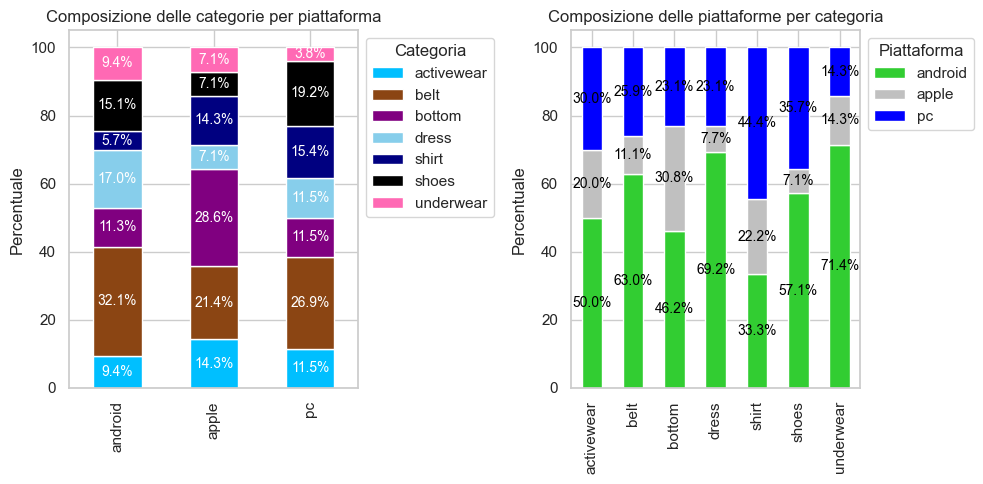

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax1 = axs[0]

platform_category_distribution = data2021.groupby(['platform', 'category']).size().unstack(fill_value=0)
platform_category_distribution_percent = platform_category_distribution.div(platform_category_distribution.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
platform_category_distribution_plot = platform_category_distribution_percent.plot(
    kind='bar', stacked=True, ax=ax1,color=[category_palette[col] for col in platform_category_distribution.columns])

for container in platform_category_distribution_plot.containers:
    values = [bar.get_height() for bar in container]
    total = sum(values)
    for bar, value in zip(container, values):
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            '{:.1f}%'.format(value),
            va='center',
            ha='center',
            fontsize=10,
            color='white'
        )

ax1.set_title('Composizione delle categorie per piattaforma')
ax1.set_xlabel('')
ax1.set_ylabel('Percentuale')
ax1.legend(title='Categoria', bbox_to_anchor=(1, 1))

ax2 = axs[1]

category_platform_distribution = data2021.groupby(['category', 'platform']).size().unstack(fill_value=0)
category_platform_distribution_percent = category_platform_distribution.div(category_platform_distribution.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
category_platform_plot = category_platform_distribution_percent.plot(
    kind='bar', stacked=True, ax=ax2,color=[platform_palette[col] for col in category_platform_distribution.columns])

for container in category_platform_plot.containers:
    values = [bar.get_height() for bar in container]
    total = sum(values)
    for bar, value in zip(container, values):
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            '{:.1f}%'.format(value),
            va='center',
            ha='center',
            fontsize=10,
            color='black'
        )

ax2.set_title('Composizione delle piattaforme per categoria')
ax2.set_xlabel('')
ax2.set_ylabel('Percentuale')
ax2.legend(title='Piattaforma', bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout()

plt.show()

La distribuzione delle categorie sulle piattaforme ci dice che le cinture sono il prodotto più venduto su Android e PC, ma non su Apple (che comunque ha le cinture al secondo posto), dove prevalgono i pantaloni. Su Android troviamo al secondo posto la più alta percentuale di vestiti, mentre da pc più scarpe. 

Android è la piattaforma che ha percentuali più alte su quasi tutto, in particolare il 71% dell'intimo viene venduto su questa piattaforma. L'unica eccezione la fanno le magliette che vengono vendute di più su pc.

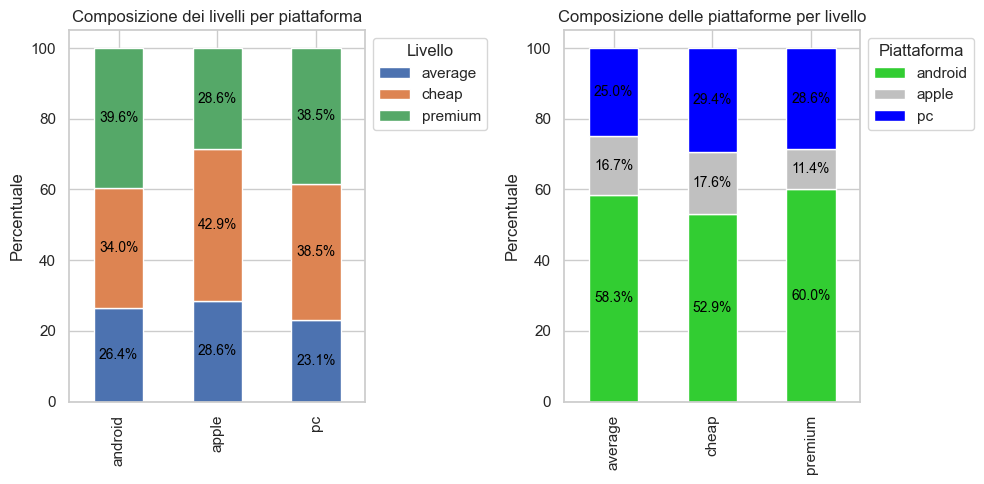

In [34]:
# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First Plot: Platform-country Distribution
ax1 = axs[0]

platform_level_distribution = data2021.groupby(['platform', 'level']).size().unstack(fill_value=0)
platform_level_distribution_percent = platform_level_distribution.div(platform_level_distribution.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
platform_level_distribution_plot = platform_level_distribution_percent.plot(kind='bar', stacked=True, ax=ax1)

for container in platform_level_distribution_plot.containers:
    values = [bar.get_height() for bar in container]
    total = sum(values)
    for bar, value in zip(container, values):
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            '{:.1f}%'.format(value),
            va='center',
            ha='center',
            fontsize=10,
            color='black'
        )

ax1.set_title('Composizione dei livelli per piattaforma')
ax1.set_xlabel('')
ax1.set_ylabel('Percentuale')
ax1.legend(title='Livello', bbox_to_anchor=(1, 1))

# Second Plot: Country-platform Distribution
ax2 = axs[1]

level_platform_distribution = data2021.groupby(['level', 'platform']).size().unstack(fill_value=0)
level_platform_distribution_percent = level_platform_distribution.div(level_platform_distribution.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
level_platform_plot = level_platform_distribution_percent.plot(
    kind='bar', stacked=True, ax=ax2,color=[platform_palette[col] for col in level_platform_distribution.columns])

for container in level_platform_plot.containers:
    values = [bar.get_height() for bar in container]
    total = sum(values)
    for bar, value in zip(container, values):
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            '{:.1f}%'.format(value),
            va='center',
            ha='center',
            fontsize=10,
            color='black'
        )

ax2.set_title('Composizione delle piattaforme per livello')
ax2.set_xlabel('')
ax2.set_ylabel('Percentuale')
ax2.legend(title='Piattaforma', bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout()

plt.show()

Per quanto riguarda il livello rispetto alle piattaforme le percentuali sono abbastanza equidivise. Possiamo comunque dire che la fascia premium e più venduta su Android, mentre su PC la troviamo a pari merito con quella economica. Apple invece (a sorpresa direi) presenta più vendite economiche.

Tutte e 3 le fasce di prezzo hanno quasi la stessa distribuzione di piattaforma, primo posto nettamente Android, secondo pc, terzo Apple.

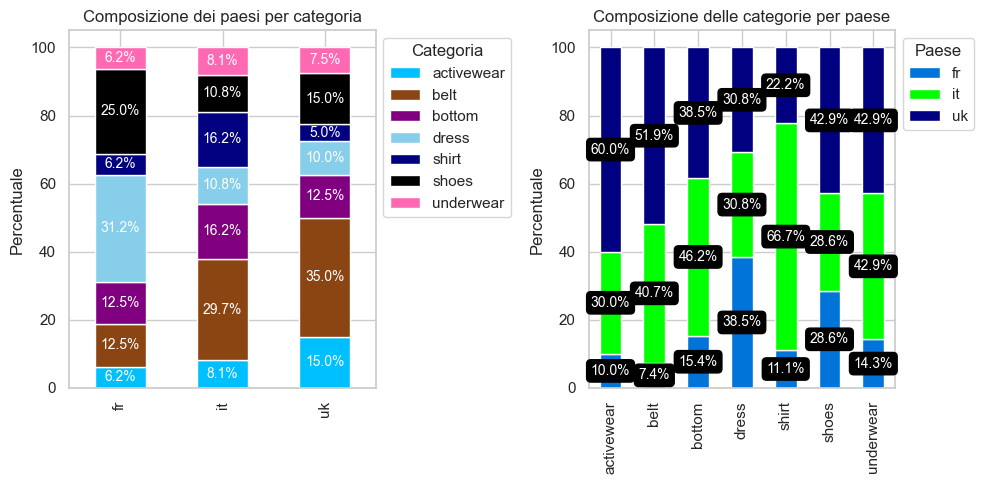

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax1 = axs[0]

country_category_distribution = data2021.groupby(['country', 'category']).size().unstack(fill_value=0)
country_category_distribution_percent = country_category_distribution.div(country_category_distribution.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
country_category_plot = country_category_distribution_percent.plot(kind='bar', 
                                                                   stacked=True, 
                                                                   ax=ax1,
                                                                  color=[category_palette[col] for col in platform_category_distribution.columns])

for container in country_category_plot.containers:
    values = [bar.get_height() for bar in container]
    total = sum(values)
    for bar, value in zip(container, values):
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            '{:.1f}%'.format(value),
            va='center',
            ha='center',
            fontsize=10,
            color='white'
        )

ax1.set_title('Composizione dei paesi per categoria')
ax1.set_xlabel('')
ax1.set_ylabel('Percentuale')
ax1.legend(title='Categoria', bbox_to_anchor=(1, 1))

ax2 = axs[1]

category_country_distribution = data2021.groupby(['category', 'country']).size().unstack(fill_value=0)
category_country_distribution_percent = category_country_distribution.div(category_country_distribution.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
category_country_plot = category_country_distribution_percent.plot(
    kind='bar', stacked=True, ax=ax2,color=[country_palette[col] for col in category_country_distribution.columns])

for container in category_country_plot.containers:
    values = [bar.get_height() for bar in container]
    total = sum(values)
    for bar, value in zip(container, values):
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            '{:.1f}%'.format(value),
            va='center',
            ha='center',
            fontsize=10,
            color='white',
             bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.3')
        )

ax2.set_title('Composizione delle categorie per paese')
ax2.set_xlabel('')
ax2.set_ylabel('Percentuale')
ax2.legend(title='Paese', bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout()

plt.show()

In Italie e in UK i prodotti più venduti sono cinture, a differenza della Francia che ha invece al primo posto i vestiti (i vestiti come abbiamo visto prima sono venduti al 70% venduti su Android, oltre che essere il secondo prodotto più venduto sulla piattaforma, inoltre i francesi sono i più grandi utilizzatori della piattaforma). 

Il 67% delle magliette è venduto in Italia, mentre il 60% dell'abbigliamento sportivo è venduto in UK. Quasi tutte le categorie sono abbastanza divise tra UK e Italia, l'unica categoria categoria in cui i francesi sono avanti sono i vestiti.

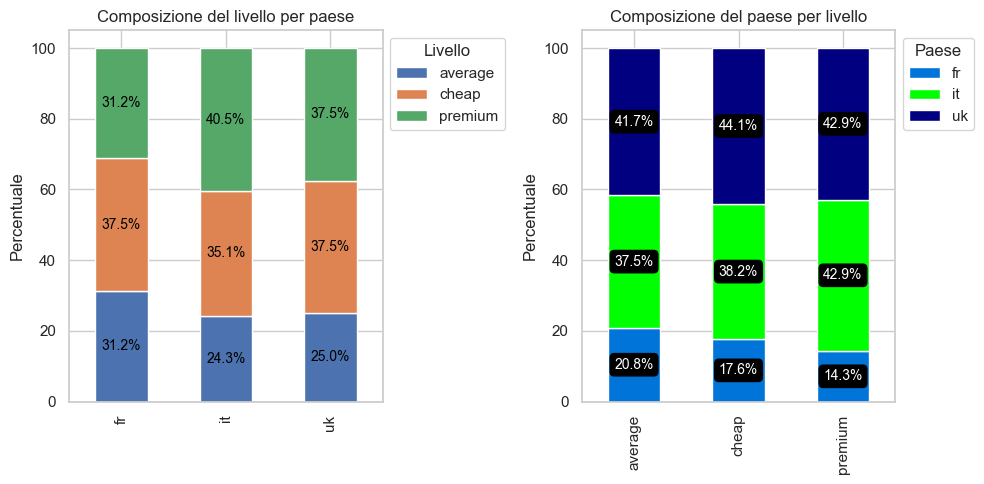

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax1 = axs[0]

country_level_distribution = data2021.groupby(['country', 'level']).size().unstack(fill_value=0)
country_level_distribution_percent = country_level_distribution.div(country_level_distribution.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
country_level_distribution_plot = country_level_distribution_percent.plot(kind='bar', stacked=True, ax=ax1)

for container in country_level_distribution_plot.containers:
    values = [bar.get_height() for bar in container]
    total = sum(values)
    for bar, value in zip(container, values):
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            '{:.1f}%'.format(value),
            va='center',
            ha='center',
            fontsize=10,
            color='black'
        )

ax1.set_title('Composizione del livello per paese')
ax1.set_xlabel('')
ax1.set_ylabel('Percentuale')
ax1.legend(title='Livello', bbox_to_anchor=(1, 1))

ax2 = axs[1]

level_country_distribution = data2021.groupby(['level', 'country']).size().unstack(fill_value=0)
level_country_distribution_percent = level_country_distribution.div(level_country_distribution.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
level_country_plot = level_country_distribution_percent.plot(
    kind='bar', stacked=True, ax=ax2,color=[country_palette[col] for col in level_country_distribution.columns])

for container in level_country_plot.containers:
    values = [bar.get_height() for bar in container]
    total = sum(values)
    for bar, value in zip(container, values):
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            '{:.1f}%'.format(value),
            va='center',
            ha='center',
            fontsize=10,
            color='white',
            bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.3')
        )

ax2.set_title('Composizione del paese per livello')
ax2.set_xlabel('')
ax2.set_ylabel('Percentuale')
ax2.legend(title='Paese', bbox_to_anchor=(1, 1))

plt.tight_layout()

plt.show()

In Italia la categoria più rappresentata è quella Premium, seguita da quella economica. Mentre in UK al primo posto a pari merito la fascia economica e quella premiun. In Francia fascia economica al primo posto, seguita a pari merito da fascia media e premium.

Su tutte le fasce la prevalenza è su UK e Italia, solo sulla fascia media (nonostante è sempre all'ultimo posto) la Francia riesce ad ottenere un 20% di vendite.

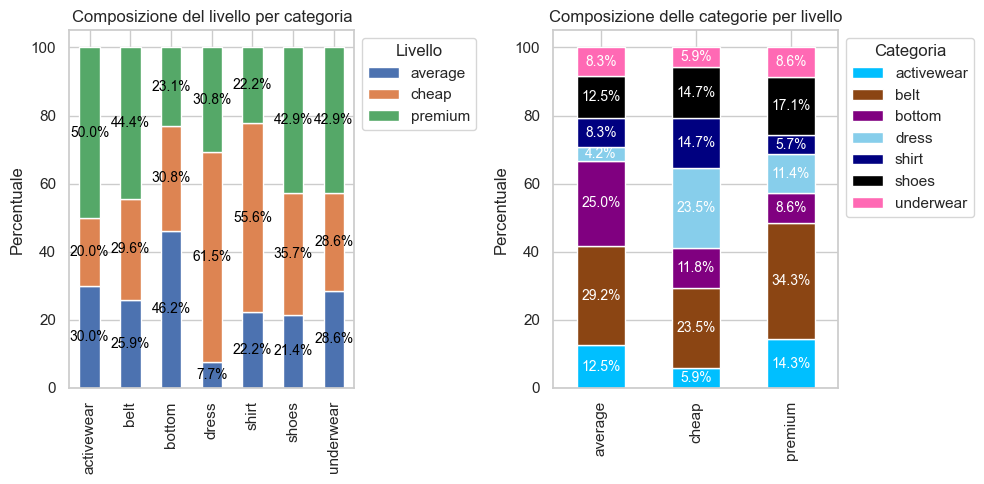

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax1 = axs[0]

category_level_distribution = data2021.groupby(['category', 'level']).size().unstack(fill_value=0)
category_level_distribution_percent = category_level_distribution.div(category_level_distribution.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
category_level_distribution_plot = category_level_distribution_percent.plot(kind='bar', stacked=True, ax=ax1)

for container in category_level_distribution_plot.containers:
    values = [bar.get_height() for bar in container]
    total = sum(values)
    for bar, value in zip(container, values):
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            '{:.1f}%'.format(value),
            va='center',
            ha='center',
            fontsize=10,
            color='black'
        )

ax1.set_title('Composizione del livello per categoria')
ax1.set_xlabel('')
ax1.set_ylabel('Percentuale')
ax1.legend(title='Livello', bbox_to_anchor=(1, 1))

ax2 = axs[1]

level_category_distribution = data2021.groupby(['level', 'category']).size().unstack(fill_value=0)
level_category_distribution_percent = level_category_distribution.div(level_category_distribution.sum(axis=1), axis=0) * 100

sns.set(style="whitegrid")
level_category_plot = level_category_distribution_percent.plot(
    kind='bar', stacked=True, ax=ax2,color=[category_palette[col] for col in platform_category_distribution.columns])

for container in level_category_plot.containers:
    values = [bar.get_height() for bar in container]
    total = sum(values)
    for bar, value in zip(container, values):
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            '{:.1f}%'.format(value),
            va='center',
            ha='center',
            fontsize=10,
            color='white'
        )

ax2.set_title('Composizione delle categorie per livello')
ax2.set_xlabel('')
ax2.set_ylabel('Percentuale')
ax2.legend(title='Categoria', bbox_to_anchor=(1, 1))

plt.tight_layout()

plt.show()

Salta all'occhio che la maggior parte dei vestiti (61%) e delle magliette (56%) venduti sono economici. Abbigliamento sportivo. Per il restoti prodotti premium sono quasi sempre i più venduti, a parte per quanto riguarda i pantaloni in cui la fascia media è più prevalente. 

Tutte le fasce hanno al primo posto le cinture (la fascia economica 23.5% insieme ai vestiti). La fascia media è molto interessata anche da pantaloni (25&), scarpe (12.5%) e abbigliamento sportivo (12.5%). La fascia economica (oltre a quanto detto prima) invece da scarpe e magliette (entrambe al 14.7%). In fascia premium a seguire troviamo scarpe (17.1%) e abbigliamento sportivo (14.3%).

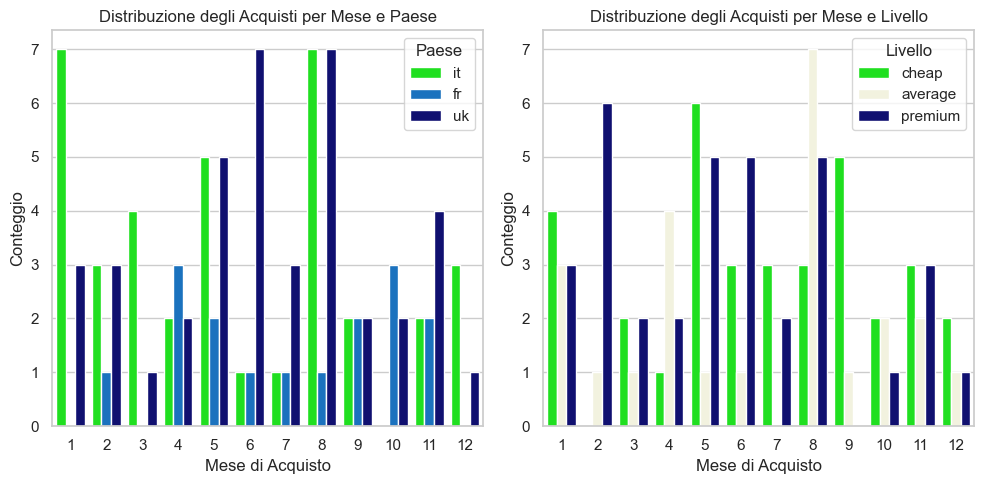

In [38]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=data2021, x='purchase_month', hue='country',palette=country_palette)
plt.title('Distribuzione degli Acquisti per Mese e Paese')
plt.xlabel('Mese di Acquisto')
plt.ylabel('Conteggio')
plt.legend(title='Paese')

plt.subplot(1, 2, 2)
sns.countplot(data=data2021, x='purchase_month', hue='level',palette=level_palette)
plt.title('Distribuzione degli Acquisti per Mese e Livello')
plt.xlabel('Mese di Acquisto')
plt.ylabel('Conteggio')
plt.legend(title='Livello')

plt.tight_layout() 
plt.show()


Riesco a ricavarci un paio di cose interessanti dal grafico sui paesi: l'UK in estate aumenta le sue vendite (il che darebbe un senso alla sua vendita abbastanza alta di prodotti sportivi). Come visto prima i mesi in cui si vende di più sono gennaio, maggio e agosto, e in tutti e 3 questi mesi l'Italia vende sempre al massimo.

Per quanto riguarda il livello si nota un'esplosione nel mese di agosto della fascia media. Le fasce in generale comunque si alternano molto e non si riesce a dargli troppo senso.

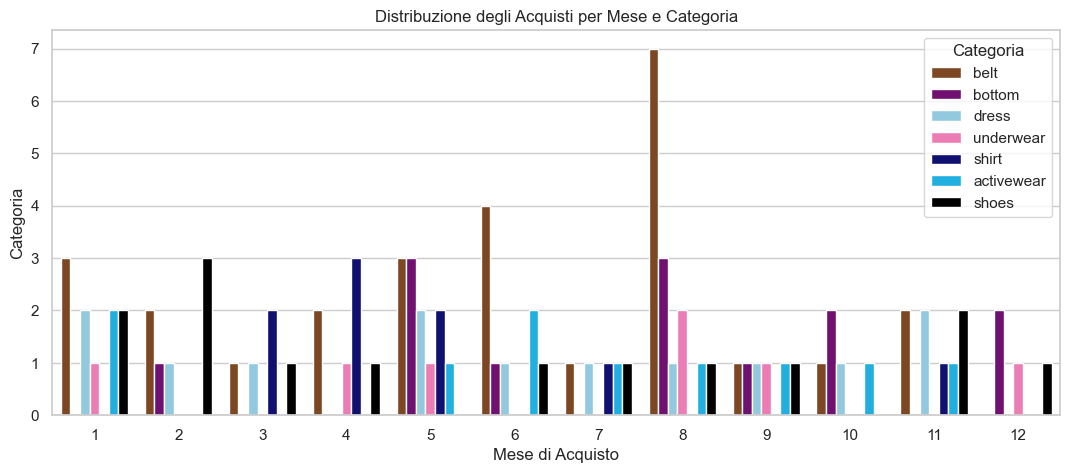

In [39]:
plt.figure(figsize=(13,5))
sns.countplot(data=data2021, x='purchase_month', hue='category',palette=category_palette)
plt.title('Distribuzione degli Acquisti per Mese e Categoria')
plt.xlabel('Mese di Acquisto')
plt.ylabel('Categoria')
plt.legend(title='Categoria')
plt.show()

C'è da considerare che i dati a disposizione non sono tantissimi ed è quindi difficile dare delle valutazioni "certe". Emerge che la maggior parte delle cinture vengono vendute ad Agosto, seguite da Giugno, Gennaio e Maggio. A Marzo si ha il picco di vendita di scarpe. A Maggio e Agosto vengono venduti anche più pantaloni. Marzo, Aprile e Maggio vedono aumentare la vendita di magliette.

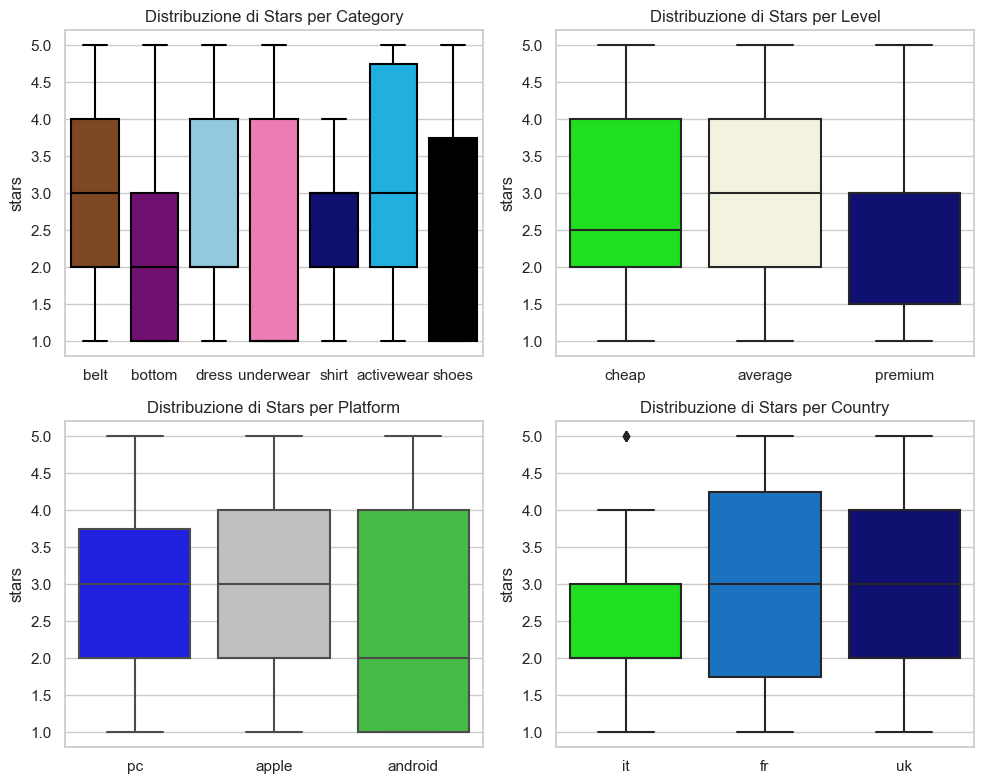

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.boxplot(x='category', y='stars', data=data2021, ax=axes[0, 0],palette=category_palette)
axes[0, 0].set_title('Distribuzione di Stars per Category')
axes[0,0].set_xlabel('')

sns.boxplot(x='level', y='stars', data=data2021, ax=axes[0, 1],palette=level_palette)
axes[0, 1].set_title('Distribuzione di Stars per Level')
axes[0,1].set_xlabel('')

sns.boxplot(x='platform', y='stars', data=data2021, ax=axes[1, 0],palette = platform_palette)
axes[1, 0].set_title('Distribuzione di Stars per Platform')
axes[1,0].set_xlabel('')

sns.boxplot(x='country', y='stars', data=data2021, ax=axes[1, 1],palette = country_palette)
axes[1, 1].set_title('Distribuzione di Stars per Country')
axes[1,1].set_xlabel('')

plt.tight_layout()
plt.show()

Da questi boxplot ricaviamo che a livello di categorie quella recensita meglio è l'abbigliamento sportivo. Magliette e pantaloni quelle che ottengono recensioni invece peggiori. 

Per quanto riguarda il livello i prodotti premium sono quelli recensiti peggio (forse aspettativa alta per i soldi spesi?).

Le recensioni più basse riguardano Android, mentre meglio su Apple, c'è comunque da dire che gli utenti Android sono molti di più e quindi è molto più probabile che arrivino anche recensioni basse.

Il paese che ha recensioni peggiori è chiaramente l'Italia, addirittura anche vedendo gli outliers non arriva praticamente mai ad ottenere più di 4 stelle. Francia e UK ottengono risultati simili tra di loro, solo un range più ampio sia in positivo che in negativo per la Francia.

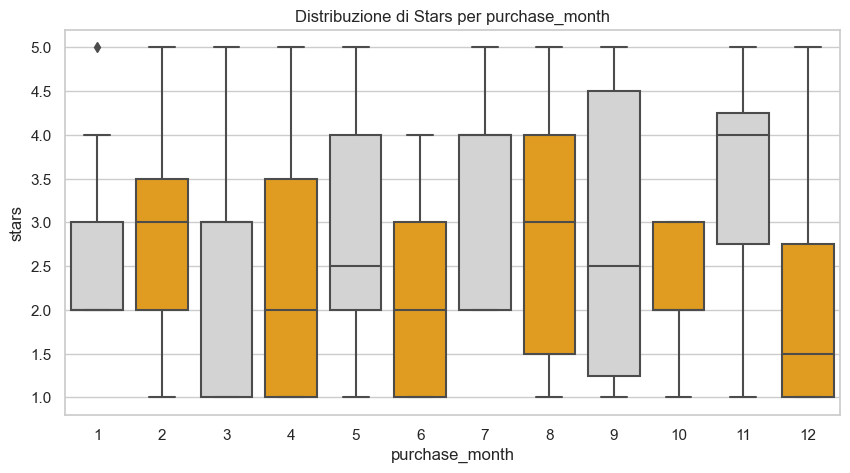

In [41]:
colors = ["#D3D3D3", "#FFA500"]
plt.figure(figsize=(10, 5))
sns.boxplot(x='purchase_month', y='stars', data=data2021,palette=colors)
plt.title('Distribuzione di Stars per purchase_month')
plt.show()

Il mese meglio recensito e "sicuro" sembra essere novembre, mentre settembre ottiene anche recensioni leggermente maggiori ma con un range molto più ampio con anche recensioni molto basse. Dicembre quello che raccoglie meno "stars".

In [42]:
#prendo lo stesso user_id una volta sola così da poter calcolare stats sul totale vendite di ogni venditore
unique_data = data2021.drop_duplicates(subset='user_uuid')
unique_data['total_sales_count'].describe()

count    49.000000
mean      1.897959
std       1.025608
min       1.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       5.000000
Name: total_sales_count, dtype: float64

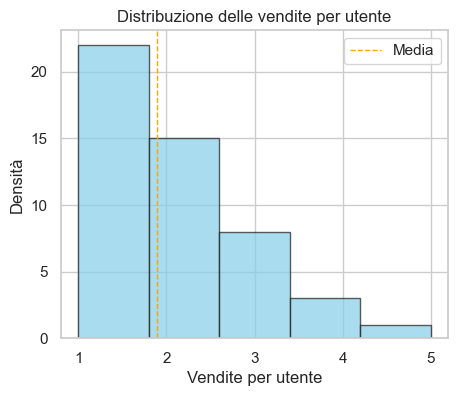

In [43]:
plt.figure(figsize=(5, 4))
plt.hist(unique_data['total_sales_count'], bins=5, edgecolor='k', color='skyblue', alpha=0.7)
plt.axvline(unique_data['total_sales_count'].mean(), color='orange', linestyle='dashed', linewidth=1, label='Media')
plt.xlabel('Vendite per utente')
plt.ylabel('Densità')
plt.title('Distribuzione delle vendite per utente')
plt.xticks(range(1, 6))

plt.legend()
plt.show()

La distribuzione è right-skewed, cioè la maggior parte degli utenti fa il minimo fa poche vendite e pochi fanno molte vendite. La media si attesta su 1.89 vendite a persona.

## 4. Clustering with K-means<a class="anchor" id="fourth-bullet"></a>

Mi interessa ottenere tre "personas" dei venditori tipo, per fare questo decido di applicare l'algoritmo di Machine Learning K-means così che in automatico mi vada a trovare i casi simili mettendoli nello stesso cluster.

In [44]:
#applico labelencoder a tutte le variabili categoriche, creando una nuova variabile e conservando quindi l'originale
label_encoder = LabelEncoder()
data2021['category_encoded'] = label_encoder.fit_transform(data2021['category'])
data2021['platform_encoded'] = label_encoder.fit_transform(data2021['platform'])
data2021['country_encoded'] = label_encoder.fit_transform(data2021['country'])
data2021['level_encoded'] = label_encoder.fit_transform(data2021['level'])


#selezioni le colonne rilevanti per il clustering
selected_features = ['purchase_month', 'purchase_year', 'level_encoded', 'stars', 'total_sales_count','country_encoded',
                     'platform_encoded','category_encoded',
                     'subscription_month']

#standardizzo le features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data2021[selected_features])

num_clusters = 3
#applico l'algoritmo KMeans ai dati cercando 3 clusters
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_model.fit(X_scaled)

#aggiungo le etichette dei cluster come colonna
data2021['cluster_label'] = kmeans_model.labels_

In [45]:
cluster_0_data2021 = data2021[data2021['cluster_label'] == 0]
cluster_1_data2021 = data2021[data2021['cluster_label'] == 1]
cluster_2_data2021 = data2021[data2021['cluster_label'] == 2]

In [46]:
print(f"Gli elementi presenti nel cluster 0 sono: {len(cluster_0_data2021)}")
print(f"Gli elementi presenti nel cluster 1 sono: {len(cluster_1_data2021)}")
print(f"Gli elementi presenti nel cluster 2 sono: {len(cluster_2_data2021)}")

Gli elementi presenti nel cluster 0 sono: 27
Gli elementi presenti nel cluster 1 sono: 27
Gli elementi presenti nel cluster 2 sono: 39


In [47]:
#salvo il dataframe aggiornato in un csv
data2021.to_csv("fashion2021.csv",index=False)

## 5. Conclusioni<a class="anchor" id="fifth-bullet"></a>

Concludiamo da dove abbiamo iniziato, diamo risposta alle domande poste inizialmente:  
* **Analizzando le variabili categoriche, quali sono le categorie e le fasce di prezzo più vendute? E da quale paese e su quale piattaforma?**

La categoria più venduta è nettamente quella delle cinture, le scarpe al secondo posto sono praticamente vendute la loro metà. Prodotto invece meno venduto è l'intimo.  
Per quanto riguarda le fasce di prezzo, la più venduta è di poco la premium su quella economica. Al terzo posto la fascia media ma comunque presenta anch'essa un buon numero di vendite. Sembra infatti che non ci sia una vera e propria fascia di prezzo che tira più di un'altra.
La maggior parte delle vendite vengono fatte dal Regno Unito di poco sopra all'Italia. Entrambe "doppiano" la Francia come vendite al terzo posto.
Per quanto riguarda la piattaforma di acquisto Android è avanti a tutti, circa il doppio delle vendite rispetto al PC al secondo posto e 4 volte più di Apple.

* **Come si relazionano tra di loro le variabili categoriche? Cosa ci dicono?**

Faccio un elenco degli insights più interessanti ricavati:

Il 70% degli acquisti da Apple vengono effettuati in UK. L'Italia ha la rappresentanza più alta di prodotti acquistati su PC, mentre UK su quelli Apple.  
Il prodotto più venduto su Apple sono le magliette, in collegamento a questo è interessante vedere come le magliette vengano vendute in maggioranza su PC (unico prodotto in cui Android non è avanti).  
Altro dato interessante riguardo le magliette è che il 66% sono vendute in Italia, esiste quindi una buona associazione Italia-PC (e Apple)-Magliette. Interessante anche notare come le cinture (prodotto più venduto) siano vendute al 52% in UK, così come l'abbigliamento sportivo il 60% sempre in UK. Particolare la distribuzione dei prodotti venduti in Francia, l'unica a non avere le cinture al primo posto ma al suo posto vestiti e scarpe.  
Il 61% dei vestiti (dress) venduti sono di fascia economica (solo il 7% è media), così come anche il 55% delle magliette. Su tutto il resto delle categorie la fascia più venduta è la premium, solo i pantaloni fanno eccezione presentando più vendite sulla fascia media (che è infatti principalmente rappresentata da pantaloni e cinture).  
Le fasce di prezzo sembrano essere abbastanza equidivise rapportate a tutte le altre variabili.

* **La data di iscrizione e la data di vendita mostrano una qualche tendenza?**

Per quanto riguarda le iscrizioni il trend sembra netto, i mesi invernali generano molti più iscritti. Per quanto riguarda invece il mese di vendita è difficile individuare un vero trend, ci sono molti alti e bassi, con Agosto, Gennaio e Maggio i mesi in cui si vende di più, mentre Dicembre, Marzo, Luglio e Ottobre i mesi in cui si vende meno.

* **Ci sono dei mesi in cui si vende più un certo tipo di prodotto, o una certa fascia di prezzo, o su un certo paese?**

In UK aumentano molto le vendite in Estate (che spiegherebbe la vendita abbastanza alta di prodotti sportivi). L'Italia è più incostante ma raggiunge il massimo nei mesi di Gennaio, Maggio e Agosto contribuendo molto a rendere i mesi di Maggio e Agosto i migliori. 
Le fasce di prezzo non sembrano comunicare insights rilevanti.


* **Quali sono le caratteristiche che più determinano una recensione alta o bassa?**

Le caratteristiche che presentano in media recensioni più alte sono: abbigliamento sportivo, prodotto average/cheap, venduto su Apple, venditore britannico (che dà più sicurezza della Francia), nel mese di Novembre.  
Quelle invece che sembrano le peggiori da questo punto di vista sono: pantaloni, prodotto premium, venduto su Android (comunque le vendite Android erano tantissime, ci può stare avere più oscillazioni), venditore italiano, nel mese di Dicembre.